# Introducción
Hoy en día hay muchos juegos y plataformas capaces de brindarnos mucha diversión y ayudarnos a escapar un poco de la monotonía de la rutina del día a día.


![Carátula de New Super Mario Bros Wii](img/NSMB-Wii.png) ![The Last of Us carátula](img/TLOU.webp)


Habiendo tantos juegos, es comprensible pensar que hay muchos datos que se recogen de estos. Pues justamente esto es lo que se piensa analizar en este trabajo.

Los datos han sido extraidos de la página [Kaggle](https://www.kaggle.com/) que nos brinda datasets en buen estado y con bastantes datos. En este caso concreto, se ha extraido de [Video Games Sales with Ratings](https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings), cuyo dataset incluye >10K filas que nos resultarán muy útiles para la predicción de nuestro atributo objetivo. Además, contaremos con 8 columnas, des del nombre del juego en concreto hasta las calificaciones dadas por la crítica/usarios que han jugado al juego.

El objetivo principal detrás de este análisis será intentar predecir cuales serán las ventas globales de un juego en concreto teniendo en cuenta todos los demás datos brindados. Para ello, seguiremos esta estructura para intentar alcanzar el objetivo propuesto:

- Preparación y preprocesado de datos
- Análisis de datos
- Diferentes modelos predictores
  - Regresor KNN
  - Regresor Lineal
  - Regresor con SVM
  - Regresor con arbol de decisión
  - Regresor con TensorFlow
- Comparativas de modelos
- Conclusión

[Link a github con este mismo notebook](https://github.com/teolicht505/Apc-Kaggle-1599156)

# Dependencias
Para este proyecto necesitaremos varias librerias:

- Pandas y Numpy: nos ayudarán a tratar los datos.
- MatplotLib, Seaborn y Plotly: serán utiles para la visualización y análisis de datos.
- SkLearn: Nos proporcionará herramientas de validación y modelos.
- TensorFlow: Nos otorgará las herramientas necesarias para hacer una red neuronal.

In [1]:
# Imports
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import plotly.graph_objs as go

from plotly.offline import iplot
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, make_scorer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold

from tensorflow import keras
from keras import layers

# Preparación y preprocesado de datos
El primer paso que es necesario hacer en un problema de regresión será mirar los datos para entenderlos y tratarlos, justamente eso es lo que vamos a hacer.

Si es estrictamente necesario también limpiaremos posibles filas con valores nulos o valores mal recogidos.

In [2]:
# Load Dataset
game_sales = pd.read_csv("Video_Games_Sales_as_at_22_Dec_2016.csv")

# Check the shape of the dataset
print(f"Dimensionality of dataset is: {game_sales.shape}")

print(game_sales.dtypes)

Dimensionality of dataset is: (16719, 16)
Name                object
Platform            object
Year_of_Release    float64
Genre               object
Publisher           object
NA_Sales           float64
EU_Sales           float64
JP_Sales           float64
Other_Sales        float64
Global_Sales       float64
Critic_Score       float64
Critic_Count       float64
User_Score          object
User_Count         float64
Developer           object
Rating              object
dtype: object


Como podemos ver, tenemos mucha información en este dataset, miraremos en profundidad cada dato más tarde.

Por el momento, es necesario observar que hay algo extraño en el tipo de uno de los atributos del dataset. Si nos fijamos bien, podemos ver que "User_Score" es de tipo "object", cuando no tendría sentido ya que debería tratarse de un número como observamos en "Critic_Score" que es un "float64". Hay algo que falla, así que miraremos los valores únicos de "User_Score" para ver si hay algún valor que no se trate de un número.

In [3]:
print(game_sales.User_Score.unique())

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


Como podemos observar, sí que son todos números excepto un valor que es 'tbd' que es una abreviación inglesa para decir que aún está por determinar (to be determined). Puesto que no sabemos el valor de esta puntuación, ya que está todavía sin determinar, reemplazaremos todos los 'tbd' por valores NaN, para poder tratarlos más fácilmente todos de golpe.

In [4]:
game_sales.User_Score.replace('tbd', np.nan, inplace=True)

game_sales.User_Score = game_sales.User_Score.astype('float64')
print(f"\nUser_Score: {game_sales.User_Score.dtypes}")


User_Score: float64


Como podemos ver, ahora sí que la columna de "User_Score" se trata correctamente como un número "float64".

Ahora trataremos de mirar si tenemos valores NaNs en nuestro dataset:

In [5]:
print("¿Hay NaNs en nuestro dataset? ->",  game_sales.isnull().values.any())

¿Hay NaNs en nuestro dataset? -> True


Como observamos sí que tenemos valores NaNs en el dataset.

Por ello vamos a observar el número de NaNs que hay en cada columna en orden descendente:

In [6]:
null_counts = game_sales.isnull().sum()
null_counts[null_counts>0].sort_values(ascending=False)

User_Score         9129
User_Count         9129
Critic_Score       8582
Critic_Count       8582
Rating             6769
Developer          6623
Year_of_Release     269
Publisher            54
Name                  2
Genre                 2
dtype: int64

Por ahora no trataremos los valores NaN, sino que observaremos los datos principales del dataset para observar si hay alguna columna que a primera vista no necesitemos para nuestro regresor:

In [7]:
pd.set_option('display.max_columns', None)
game_sales.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Si miramos los ejemplos, observaremos que tenemos las ventas de EU, NA, JP y otras. Estas columnas harian nuestro regresor perfecto ya que las ventas globales son la suma de todas las demás ventas, es por ello que pienso que no es algo correcto a tener en cuenta ya que no tendría ningun sentido el predecir las ventas globales sabiendo las ventas de todos estos lugares. Además de esto, tenemos la columna del nombre del juego, que no tendria sentido añadir ya que el nombre del juego no puede tener relación con las ventas globales. 

Por tanto, eliminaremos las siguientes columnas:

- NA_Sales, EU_Sales, JP_Sales, Other_Sales
- Name

In [8]:
game_sales.drop(columns=["Name", "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"], inplace=True)
game_sales.head(5)

,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii,2006.0,Sports,Nintendo,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,NES,1985.0,Platform,Nintendo,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Wii,2008.0,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii,2009.0,Sports,Nintendo,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,GB,1996.0,Role-Playing,Nintendo,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Ahora haremos un primer tratamiento de los NaN, lo que haremos será eliminar las filas que contengan NaNs para que la distribución no se vea afectada:

In [9]:
game_sales_analysis = game_sales.dropna()

Más tarde intentaremos no eliminar tantas filas intentando deshacernos de columnas que no nos aporten información para nuestros regresores según nuestro análisis de datos.

Guardamos el dataset para el análisis como "game_sales_analysis"

# Análisis de datos

Primero observaremos un poco valores interesantes que nos aporten las columnas numéricas como bien podria ser la media, desviación estandar, valores máximos y mínimos...

In [10]:
game_sales_analysis.describe()

,Year_of_Release,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000,6825.000000
mean,2007.436777,0.777590,70.272088,28.931136,7.185626,174.722344
std,4.211248,1.963443,13.868572,19.224165,1.439942,587.428538
min,1985.000000,0.010000,13.000000,3.000000,0.500000,4.000000
25%,2004.000000,0.110000,62.000000,14.000000,6.500000,11.000000
50%,2007.000000,0.290000,72.000000,25.000000,7.500000,27.000000
75%,2011.000000,0.750000,80.000000,39.000000,8.200000,89.000000
max,2016.000000,82.530000,98.000000,113.000000,9.600000,10665.000000


Observamos datos muy interesantes, como las medias y desviaciones son bastante diferentes, así como los valores máximos y mínimos. 

También es interesante observar como la crítica de los usuarios "User_Score" sobre 10 se acerca bastante a la crítica de Metacritic "Critic_Score" sobre 100, teniendo en cuenta que hay muchas más críticas de los usuarios en algunos casos con un máximo de 10665 en "User_Count" mientras que el máximo de las críticas de Metacritic "Critic_Count" es de 113.

Ahora pasaremos a observar algunos de los valores categóricos, que son los siguientes:

In [11]:
game_sales_analysis.select_dtypes("object").dtypes

Platform     object
Genre        object
Publisher    object
Developer    object
Rating       object
dtype: object

Empezaremos por el atributo "Genre" que podría ser interesante para la regresión:

In [12]:
# We take the 'Genre' attribute values and the corresponding counts.
labels = game_sales_analysis["Genre"].unique().tolist()
values = game_sales_analysis["Genre"].value_counts().tolist()

# We generate the pie chart of the 'Genre' attribute.
trace = go.Pie(labels=labels,
               values=values,
               textinfo='label+percent',
               hole=0.3)

data = [trace]

figure = go.Figure(data)
figure.update_layout(title="Proporción Genre", width=700, height=700)

iplot(figure)

Podemos observar que la distribución no está muy bien repartida ya que la mayoría de juegos van hacia los de Deporte, Carreras y Plataformas respectivamente. Luego los demás géneros se estratifican más y no hay tanta cantidad como en los que ya he mencionado.

El último atributo categórico que podría ser de importancia se trata de "Platform", con la siguiente proporción:

In [13]:
# We take the 'Platform' attribute values and the corresponding counts.
labels = game_sales_analysis["Platform"].unique().tolist()
values = game_sales_analysis["Platform"].value_counts().tolist()

# We generate the pie chart of the 'Platform' attribute.
trace = go.Pie(labels=labels,
               values=values,
               textinfo='label+percent',
               hole=0.3)

data = [trace]

figure = go.Figure(data)
figure.update_layout(title="Proporción Platform", width=800, height=700)

iplot(figure)

De la misma manera que ocurre con "Genre", no hay demasiada distribución entre todos los valores, hay algunas categorias de las que tenemos muchos ejemplos como bien podría ser de "Wii" o de "DS" mientras que otras plataformas escasean más, como "DC" o "PSV".

Otra distribución que pienso que puede ser importante sería la de "Critic_Score" así como la de "User_Score", que como he explicado antes, deberán ser muy parecidas ya que la media de los dos es más o menos la misma.

Vamos a observar esto con un histograma:

In [14]:
# We generate the histogram of the 'Region' attribute.
figure = px.histogram(game_sales_analysis, x='Critic_Score', color='Critic_Score')
figure.update_layout(title="Histograma", bargap=0.4, width=700, height=500)

iplot(figure)

# We generate the histogram of the 'Region' attribute.
figure = px.histogram(game_sales_analysis, x='User_Score', color='User_Score')
figure.update_layout(title="Region Histogram", bargap=0.4, width=700, height=500)

iplot(figure)

Como cabía esperar, las dos distribuciones son muy parecidas, cosa que tiene sentido ya que la opinión general de un juego tiende a ser más o menos la misma respecto a un usuario promedio que a un experto. Más o menos, las dos gráficas siguen una distribución normal que tiende un poco más hacia notas positivas >6/10 / >60/100. Podría sernos útil usar solo 1 de los 2 atributos visto su gran parecido, para no perder tantas filas pero conservar la máxima información.

Otra cosa también interesante sería observar la relación entre atributos: 

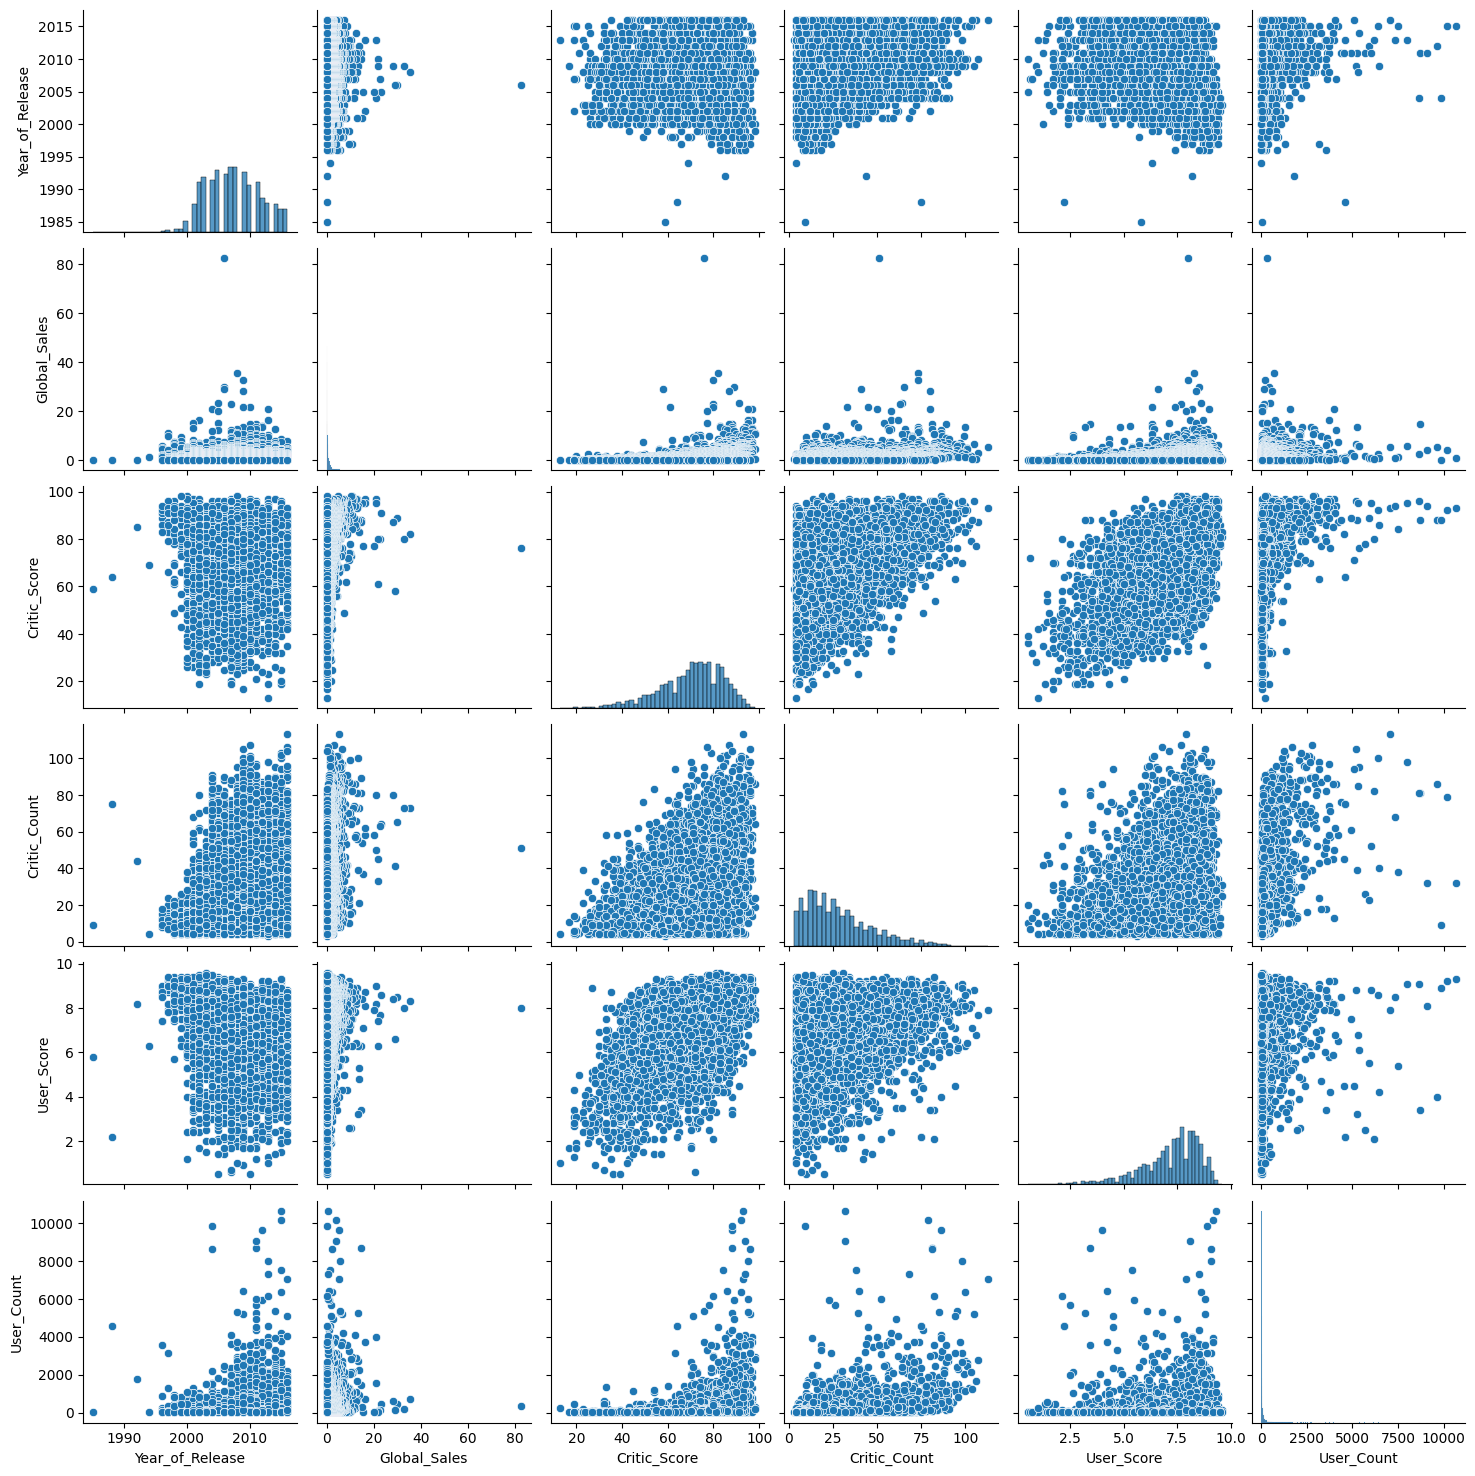

In [15]:
sns.pairplot(game_sales_analysis)

Podemos extraer también mucha información de esta tabla de relación, de hecho se nos confirma lo que estabamos sospechando de que debe haber alguna relación entre la puntuación de la crítica del juego y las propias ventas globales.

Para ver esto más claramente, podemos observar el mapa de calor respecto las correlaciones entre atributos. Para tener en cuenta todos los atributos, pasaré a númericos todos los atributos categóricos para poder observar posibles correlaciones entre ellos. Para que se vea facilmente en la tabla, pasaré los atributos categóricos a numéricos con  `OrdinalEncoder`

<AxesSubplot: >

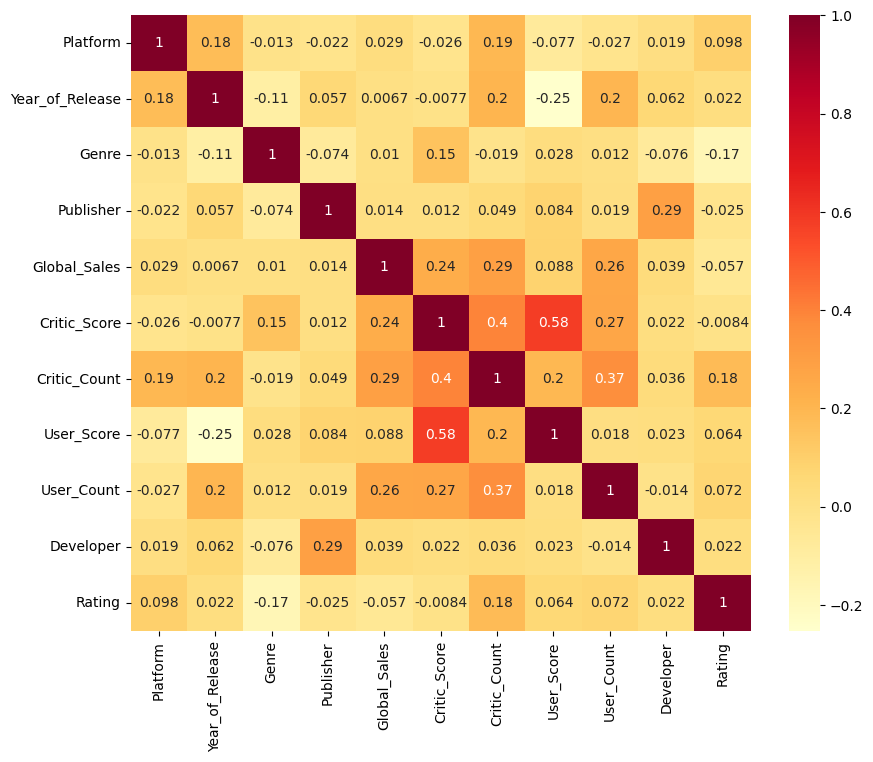

In [16]:
enc = OrdinalEncoder()
game_sales_dist = game_sales_analysis.copy(deep=True)
game_sales_dist[["Genre", "Rating", "Platform", "Publisher", "Developer"]] = enc.fit_transform(game_sales_dist[["Genre", "Rating", "Platform", "Publisher", "Developer"]])

fig = plt.figure(figsize=(10, 8))
sns.heatmap(game_sales_dist.corr(numeric_only=True), annot=True, cmap='YlOrRd')

Para observar nuestro valor objetivo mejor, nos enfocaremos solo en la fila de nuestra variable objetivo:

<AxesSubplot: >

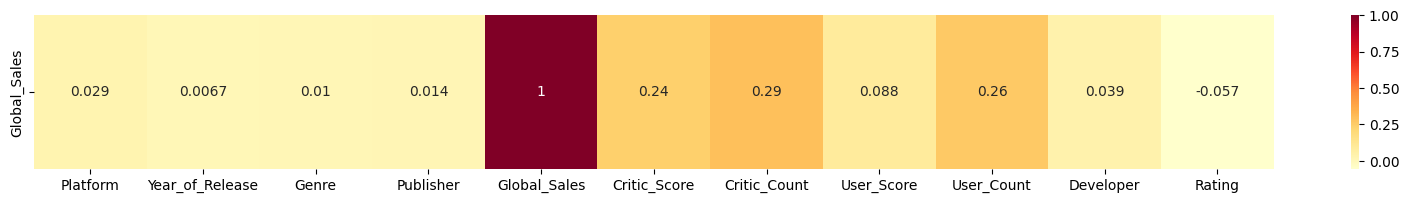

In [17]:
corr = game_sales_dist.corr(numeric_only=True)
global_sales_corr = corr[['Global_Sales']].transpose()

fig = plt.figure(figsize=(20, 2))
sns.heatmap(global_sales_corr, annot=True, cmap='YlOrRd')

Con un primer vistazo podemos darnos cuenta de que las variables más correlacionadas con las ventas globales se tratan de:

- Critic_Score
- Critic_Count
- User_Count

Aun sin tener una correlación muy grande, intentaremos hacer que los modelos sean lo más precisos posibles, sin esperar resultados demasiado espectaculares.

Para intentar conseguir la máxima cantidad de filas, cogeremos solo estas columnas que nos interesan para el dataset y entonces eliminaremos los NaNs:

In [18]:
game_sales = game_sales[["Critic_Score", "Critic_Count", "User_Count", "Global_Sales"]]
game_sales.dropna(inplace=True)

Ahora sí podemos preparar nuestras X (atributos) e y (target) para que nuestros modelos sean capaces de usarlo, lo que haremos será normalizar nuestros atributos, además de eso mostraremos con una reducción de componentes PCA como se ven todos los atributos respecto nuestro target "Global_Sales", esto lo haremos con `StandardScaler` y `PCA` a un componente

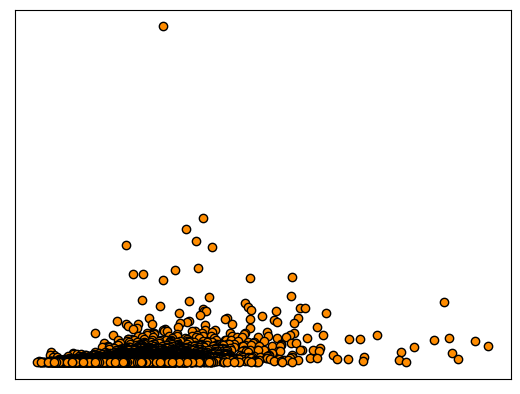

In [19]:
X = game_sales.drop(columns="Global_Sales")

scaler = StandardScaler()
X = scaler.fit_transform(X)

y = game_sales.Global_Sales

pca = PCA(n_components=1)
X_plot = pca.fit_transform(X)

# Plot outputs
plt.scatter(X_plot, y, edgecolor="black", c="darkorange", label="data")

plt.xticks(())
plt.yticks(())

plt.show()

Como observamos, los atributos hacen una forma muy lineal, por lo que quizás sería interesante más que buscar un regresor multivariado, hacer modelos lineales ya que a simple vista podemos observar que conseguiremos mejores resultados.

# Modelos

Ahora que tenemos todos los datos listos, ya solo haría falta pasar a los modelos, en todos usaremos la métrica del MSE (mean squared error) para medir que tan buenos son los modelos. Esta métrica cuanto más se acerque a 0 nos indicará que el modelo es mejor. Entonces, si el MSE llegase a ser 0 querria decir que la clasificación es perfecta ya que no habria error.

Inicializaremos un diccionario donde iremos guardando los scores finales de cada modelo para hacer al final una comparativa:

In [20]:
model_scores = {
    "knn": 0,
    "linear_regr": 0,
    "linear_SVR": 0,
    "decission_tree": 0,
    "keras_neural_net": 0
}

Ahora en todos los modelos haremos un k-cross validation con k=1000 grupos, excepto en el caso de la red neuronal que será una k=10 debido a que es bastante más lento a la hora de generar modelos y tardaría demasiado en darnos un resultado.

En algunos modelos también se podrá ver una gráfica donde se ve más claramente el regresor. Esto lo hacemos gracias a un PCA, que reduce los componentes de los atributos a 1 característica, permitiendonos ver en un espacio bidimensional nuestro modelo para observar más claramente nuestro modelo. 

## KNN

En el caso de KNN intentaremos buscar la mejor K de entre 1 y 100. Esto lo haremos cogiendo la K que mejor MSE nos aporte.

Indicaremos con una gráfica como va aumentando el valor del MSE negativo para que se vea claramente el impacto de la K en el MSE.

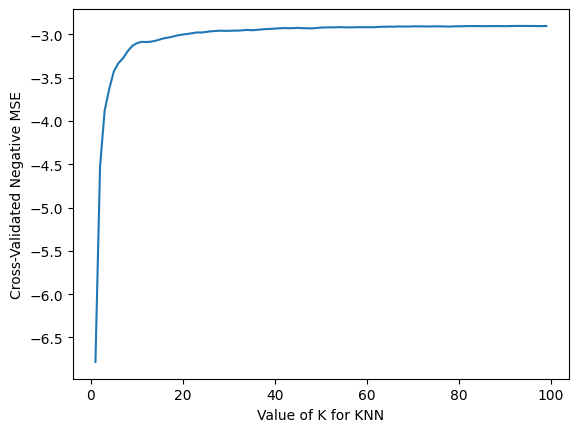


Best MSE goes to k = 95 with value -2.904339723576238


In [22]:
# choose k between start_range to 600
start_range = 1
k_range = range(start_range, 100)
k_scores = []

# calculate different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=1000, scoring='neg_mean_squared_error')
    k_scores.append(scores.mean())


plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Negative MSE')
plt.show()

print(f"\nBest MSE goes to k = {start_range + k_scores.index(max(k_scores)) + 1} with value {max(k_scores)}")
model_scores["knn"] = max(k_scores)

## Regresor Lineal

MSE score for linear regressor was: -2.9925693803439417


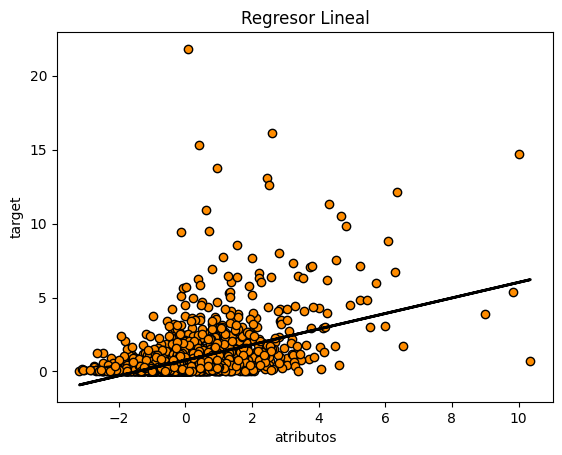

In [23]:
lineal_regressor = LinearRegression()
scores = cross_val_score(lineal_regressor, X, y, cv=1000, scoring='neg_mean_squared_error')

print(f"MSE score for linear regressor was: {np.mean(scores)}")
model_scores["linear_regr"] = np.mean(scores)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pca = PCA(n_components=1)

x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

lineal_regressor.fit(x_train, y_train)

y_pred = lineal_regressor.predict(x_test)

# Plot outputs
plt.scatter(x_test, y_test, edgecolor="black", c="darkorange", label="data")
plt.plot(x_test, y_pred, color="black", linewidth=2)

plt.xlabel("atributos")
plt.ylabel("target")
plt.title("Regresor Lineal")

plt.show()

## Regresor SVM

In [24]:
SVM_regressor = LinearSVR()
scores = cross_val_score(SVM_regressor, X, y, cv=1000, scoring='neg_mean_squared_error')

print(f"MSE score for SVM was: {np.mean(scores)}")
model_scores["linear_SVR"] = np.mean(scores)

MSE score for SVM was: -3.193779648988469


## Regresor arbol de decisión

MSE score for Decision Tree was: -2.93183055832965


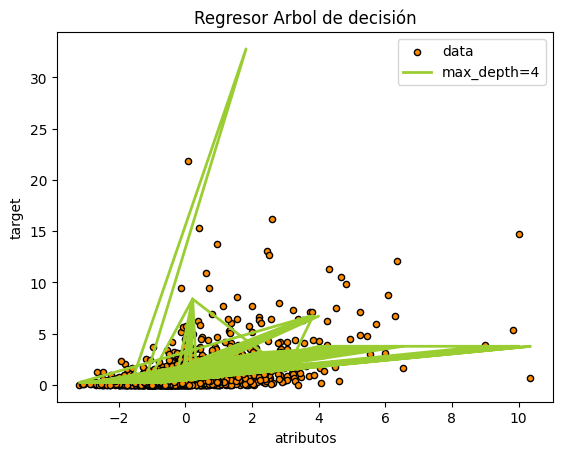

In [25]:
DT_Regr = DecisionTreeRegressor(max_depth=4)
scores = cross_val_score(DT_Regr, X, y, cv=1000, scoring='neg_mean_squared_error')

print(f"MSE score for Decision Tree was: {np.mean(scores)}")
model_scores["decission_tree"] = np.mean(scores)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
pca = PCA(n_components=1)

x_train = pca.fit_transform(x_train)
x_test = pca.fit_transform(x_test)

DT_Regr.fit(x_train, y_train)

y_pred = DT_Regr.predict(x_test)

# Plot the results
plt.figure()
plt.scatter(x_test, y_test, s=20, edgecolor="black", c="darkorange", label="data")
plt.plot(x_test, y_pred, color="yellowgreen", label="max_depth=4", linewidth=2)
plt.xlabel("atributos")
plt.ylabel("target")
plt.title("Regresor Arbol de decisión")
plt.legend()
plt.show()

## Red Neuronal TensorFlow

En el caso de la red neuronal haremos un primer modelo para estimar aproximadamente cuantás épocas serán necesarias para obtener un buen modelo, además de probar diferentes parámetros como el batch_size. Esto es para que a la hora de hacer la validación cruzada el modelo sea lo más optimo posible:

In [26]:
train_dataset = game_sales.sample(frac=0.8, random_state=42)
test_dataset = game_sales.drop(train_dataset.index)

train_labels = train_dataset.pop('Global_Sales')
test_labels = test_dataset.pop('Global_Sales')

def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(128, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                )
  return model

model = build_model()
model.summary()

EPOCHS = 120
batch_size = 32

history = model.fit(
  np.array(train_dataset), np.array(train_labels),
  epochs=EPOCHS, validation_split = 0.2, verbose=1,
  batch_size = batch_size
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               512       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
141/141 [==============================] - 1s 3ms/step - loss: 1069.9523 - val_loss: 12.0393
Epoch 2/120
141/141 [==============================] - 0s 2ms/step - loss: 488.0817 - val_loss: 1047.7961
Epoch 3/120
141/141 [==============================] - 0s 2ms/step - loss: 581.1066 - val_loss: 6.1217
Ep

,loss,val_loss,epoch
115,3.186659,4.101071,115
116,3.204039,4.083096,116
117,3.173435,4.096221,117
118,3.195247,4.038728,118
119,3.189292,4.299435,119


In [27]:
print(np.argmin(hist.loss))
print(hist.loss.min())

92
3.161297082901001


Tenemos un primer valor de MSE y tras varias pruebas las épocas rondan las 108, además un batch_size de 32 nos da buenos resultados. Validaremos nuestro modelo con estas características y guardaremos la puntuación para la comparativa entre todos los modelos. Como he dicho anteriormente, en este caso la cross-validation será con k=10 debido a la lentitud en generar modelos de la red neuronal:

In [28]:
EPOCHS = 108
batch_size = 32

mse_per_fold = []
n_folds = 10

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):

  # Build our model with last function
  model = build_model()

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data
  history = model.fit(np.array(X)[train], np.array(y)[train],
              batch_size=batch_size,
              epochs=EPOCHS, verbose=0)

  # Get MSE
  score = model.evaluate(np.array(X)[test], np.array(y)[test], verbose=0)
  print(f'Score for fold {fold_no}: MSE: {score}')
  mse_per_fold.append(score)

  # Increase fold number
  fold_no = fold_no + 1

print('------------------------------------------------------------------------')
print(f"MSE with {n_folds} folds was: {np.mean(np.array(mse_per_fold))}")
model_scores["keras_neural_net"] = np.mean(np.array(mse_per_fold))

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: MSE: 1.049701452255249
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: MSE: 3.178703546524048
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: MSE: 2.248660087585449
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: MSE: 1.9424585103988647
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: MSE: 12.42647647857666
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: MSE: 2.4588356018066406
------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: MSE: 3.8716163635253906
-------------------------------

# Comparativa entre modelos

In [29]:
# We create a DataFrame of the results obtained for each model.
results = pd.DataFrame()
results['Model'] = model_scores.keys()
results['MSE'] = [-act_score if (act_score < 0) else act_score for act_score in model_scores.values()]

# We sort the results by the MSE value.
results = results.sort_values('MSE')

# We create the MSE chart.
mae_figure = px.bar(results, x='MSE', y='Model', color='Model', orientation='h')
mae_figure.update_layout(title="Mean Squared Error (MSE)", width=900, height=300)

iplot(mae_figure)

Podemos observar como el modelo KNN nos consigue el error quadrático más bajo y por tanto ha sido el que mejores resultados ha dado.

# Conclusión

En conclusión hemos conseguido crear nuestro modelo regresor con el mínimo error posible. Aunque ha sido dificil, puesto que no había mucha relación entre los atributos aportados y las ventas globales que tratabamos de predecir.

Además, ha sido también muy interesante este trabajo ya que me ha permitido investigar sobre varios de los modelos que he usado y no tenía tanto por la mano. Además ha sido gratificante ver como a partir de una base de datos de cero he tenido que buscar mi propio objetivo y resolverlo por mí mismo.